In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

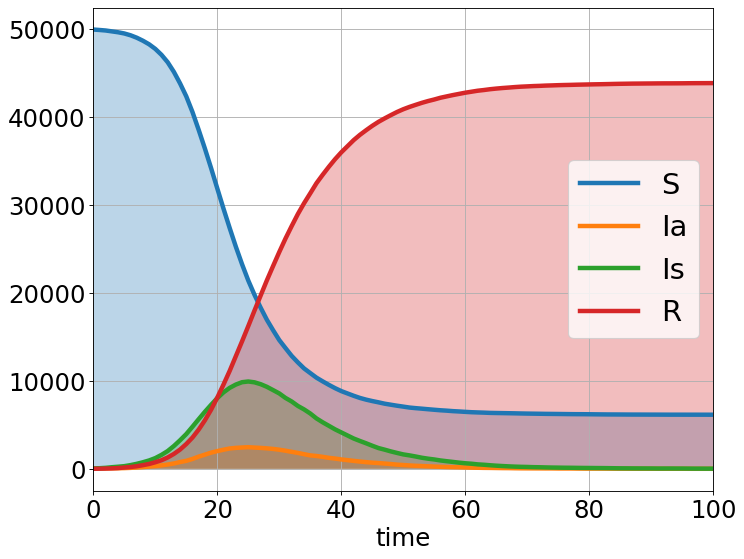

In [3]:
M  = 2          # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SIR_traj.npy', data_array)

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.fill_between(t, 0, N - np.sum(data_array[:, :], axis=1), alpha=0.3)
plt.plot(t, N - np.sum(data_array[:, :], axis=1), '-', label='R', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 20
Nf_inference = Tf_inference + 1

x = np.load('latent_SIR_traj.npy').astype('float')
x = x[:Nf_inference]

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, Ni)

In [5]:
# a filter that gives the symptomatic infected
fltr1 = np.kron([0, 0, 1],np.identity(M))
print(fltr1)

fltr2 = np.kron([[0, 1, 0], [0, 0, 1]], np.identity(M))
print(fltr2)

N_change = 10 
obs1 = np.einsum('ij,kj->ki', fltr1, x[:N_change])
obs2 = np.einsum('ij,kj->ki', fltr2, x[N_change:])

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [7]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

fltr = pyross.utils.make_fltr([fltr1, fltr2], [10, Nf_inference-10])
obs = np.array([*obs1] + [*obs2])
x0 = x[0] 
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp) 
print(end_time - start_time)

261.8604349693004
0.2540271282196045


In [10]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4

param_priors = {
    'alpha':{
        'mean': 0.2, 
        'std': 0.05, 
        'bounds': [eps, 0.5]
    },
    'beta':{
        'mean': 0.04, 
        'std': 0.1,
        'bounds': [eps, 0.4]
    }, 
    'gIa':{
        'mean': 0.13, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }
}

Ia0_g = (Ia0)
Ia_std = Ia0_g*10
bounds_for_Ia = np.tile([0.1, 1000], M).reshape(M, 2)

S0_g = (S0) # need the sum of S0_g + I0 (observed in this case) over each age group to be smaller than fi 
S_std = Ia_std*5
bounds_for_S = np.array([(0.1, N) for N in Ni]).reshape(M, 2)

init_fltr = np.repeat([True, True, False], M)

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  

init_priors = {
    'independent':{
        'fltr': init_fltr, 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S_std, *Ia_std], 
        'bounds': [*bounds_for_S, *bounds_for_Ia]
    }
}
start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors, 
                                            tangent=True,
                                            global_max_iter=20, global_atol=1, 
                                            verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=3913543461, Mon Jun 29 16:47:00 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 3.022524646755700e+03 1.0e+00 9.38e-01  5e-02  1e+03 0:00.1
    2     32 4.481572487797986e+04 1.3e+00 9.15e-01  4e-02  1e+03 0:00.3
    3     48 2.748545302702697e+03 1.5e+00 8.48e-01  4e-02  1e+03 0:00.4
Optimal value (global minimisation):  664.4591985619679
Starting local minimisation...
Optimal value (local minimisation):  274.7835603075397
3.8819689750671387


In [12]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = res['map_params_dict']
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, Ia0, Is0)

map_x0 = res['map_x0']
print('\n Inferred initial conditons: ') 
print(map_x0.astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.1816504653259219, 'beta': 0.020513349538377846, 'gIa': 0.11480981078672137, 'gIs': 0.1475312150666749, 'fsa': array([1., 1.])}

 True initial conditions: 
[12460. 37460.] [20 20] [20 20]

 Inferred initial conditons: 
[12342 37472    33     3    20    20]


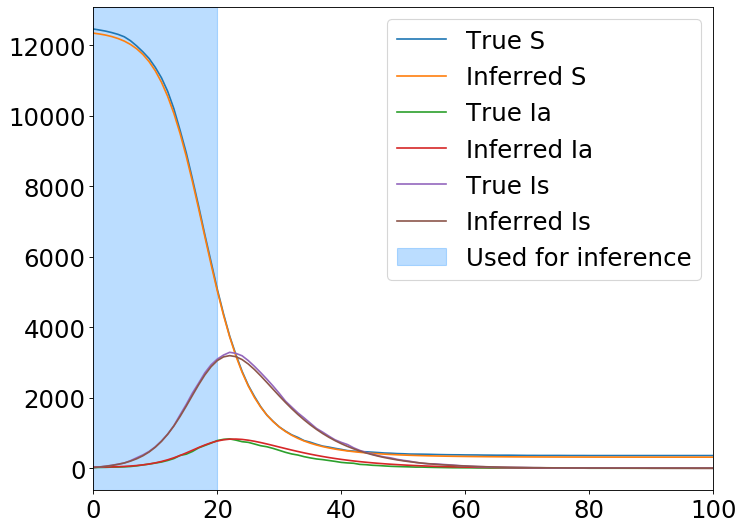

In [13]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(map_x0, 0, Tf, Nf)
x = np.load('latent_SIR_traj.npy').astype('float')
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,0], label='True S')
plt.plot(x_det[:, 0], label='Inferred S')
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()